In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

import yfinance as yf

from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,Dropout,GRU

In [2]:
#Cargar los datos
company = 'MXN=X'
ticker = yf.Ticker(company)
hist = ticker.history(start = '2012-1-1', end='2022-1-1')

hist.tail()

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
2021-12-27 00:00:00+00:00,20.608999,20.740200,20.576200,20.607201,0,0.0,0.0
2021-12-28 00:00:00+00:00,20.693199,20.723301,20.550900,20.683599,0,0.0,0.0
2021-12-29 00:00:00+00:00,20.651899,20.669600,20.541201,20.662201,0,0.0,0.0
2021-12-30 00:00:00+00:00,20.557501,20.608101,20.476900,20.558001,0,0.0,0.0
2021-12-31 00:00:00+00:00,20.462200,20.495979,20.324760,20.459101,0,0.0,0.0


In [3]:
#Preparar los datos
scaler = MinMaxScaler(feature_range=(0,1))
scaled_data = scaler.fit_transform(hist['Close'].values.reshape(-1,1))

prediction_days = 60

x_train = []
y_train = []

for x in range(prediction_days,len(scaled_data)):
  x_train.append(scaled_data[x-prediction_days:x,0])
  y_train.append(scaled_data[x,0])

x_train,y_train = np.array(x_train),np.array(y_train)
x_train = np.reshape(x_train,(x_train.shape[0],x_train.shape[1],1))

x_train.shape

(2549, 60, 1)

In [4]:
#Contruir el modelo
model = Sequential()

model.add(GRU(units=50,return_sequences = True, input_shape=(x_train.shape[1],1)))
model.add(Dropout(0.2))
model.add(GRU(units=50,return_sequences = True))
model.add(Dropout(0.2))
model.add(GRU(units=50))
model.add(Dropout(0.1))
model.add(Dense(units=1))

model.compile(optimizer='adam', loss='mean_squared_error')

model.fit(x_train,y_train,epochs=25,batch_size=32)

Epoch 1/25
80/80 [==============================] - 10s 61ms/step - loss: 0.0124
Epoch 2/25
80/80 [==============================] - 5s 62ms/step - loss: 0.0021
Epoch 3/25
80/80 [==============================] - 5s 61ms/step - loss: 0.0020
Epoch 4/25
80/80 [==============================] - 6s 72ms/step - loss: 0.0016
Epoch 5/25
80/80 [==============================] - 6s 73ms/step - loss: 0.0015
Epoch 6/25
80/80 [==============================] - 6s 69ms/step - loss: 0.0013
Epoch 7/25
80/80 [==============================] - 8s 98ms/step - loss: 0.0014
Epoch 8/25
80/80 [==============================] - 7s 90ms/step - loss: 0.0013
Epoch 9/25
80/80 [==============================] - 6s 70ms/step - loss: 0.0013
Epoch 10/25
80/80 [==============================] - 6s 70ms/step - loss: 0.0011
Epoch 11/25
80/80 [==============================] - 6s 72ms/step - loss: 0.0011
Epoch 12/25
80/80 [==============================] - 6s 74ms/step - loss: 0.0012
Epoch 13/25
80/80 [=================

In [7]:
#Cargar los datos del test
from datetime import datetime, timedelta

today = datetime.now()
yesterday = (today - timedelta(days=1)).strftime("%Y-%m-%d")

if today.weekday() == 5:  # Saturday
    yesterday = (today - timedelta(days=2)).strftime("%Y-%m-%d")
elif today.weekday() == 6:  # Sunday
    yesterday = (today - timedelta(days=3)).strftime("%Y-%m-%d")
hist_test = ticker.history(start = '2022-1-1', end= yesterday )
actual_prices = hist_test["Close"].values

total_dataset = pd.concat((hist['Close'],hist_test['Close']),axis=0)
model_inputs = total_dataset[len(total_dataset)-len(hist_test)-prediction_days:].values
model_inputs = scaler.transform(model_inputs.reshape(-1,1))

In [8]:
tracker = yf.Ticker(company)
recent_hist = tracker.history(start = '2023-1-1', end=yesterday)
recent_hist.tail()

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
2023-07-13 00:00:00+01:00,16.896429,16.957581,16.848499,16.896429,0,0.0,0.0
2023-07-14 00:00:00+01:00,16.846630,16.915159,16.802099,16.846630,0,0.0,0.0
2023-07-17 00:00:00+01:00,16.738701,16.892900,16.693399,16.738701,0,0.0,0.0
2023-07-18 00:00:00+01:00,16.713699,16.759621,16.687099,16.713699,0,0.0,0.0
2023-07-19 00:00:00+01:00,16.752150,16.783381,16.711300,16.752150,0,0.0,0.0


In [9]:
x_test = []

for x in range(prediction_days,len(model_inputs)):
  x_test.append(model_inputs[x-prediction_days:x,0])

x_test = np.array(x_test)
x_test = np.reshape(x_test,(x_test.shape[0],x_test.shape[1],1))

predicted_prices = model.predict(x_test)
predicted_prices = scaler.inverse_transform(predicted_prices)

13/13 [==============================] - 2s 24ms/step


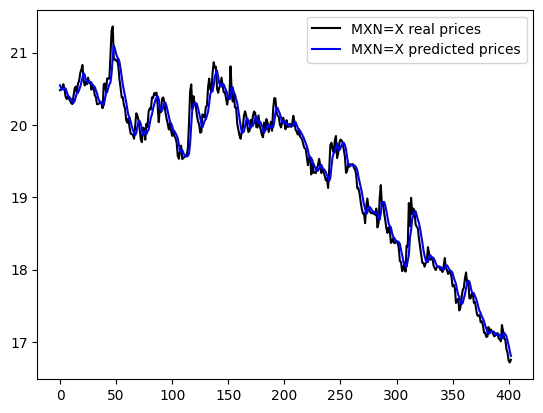

In [10]:
plt.plot(actual_prices,color="black",label=f"{company} real prices")
plt.plot(predicted_prices,color="blue",label=f"{company} predicted prices")
plt.legend()
plt.show()

In [11]:
rentability = 1
for i in range(1,len(actual_prices)):
  if predicted_prices[i] > actual_prices[i-1]:
    rentability*= actual_prices[i]/actual_prices[i-1]

print((rentability-1)*100,"%")

-10.745563494577448 %


In [12]:
# Print the predicted price for the next day
last_predicted_price = predicted_prices[-1][0]
print("Predicted Price for the Next Day:", last_predicted_price)

Predicted Price for the Next Day: 16.804798


In [13]:
# Make Predictions for the Next 7 Days
predicted_prices = []
current_input = x_test[-1]

for _ in range(7):
    current_input = np.reshape(current_input, (1, prediction_days, 1))
    next_price = model.predict(current_input)
    predicted_prices.append(next_price)
    current_input = np.append(current_input[:, 1:, :], np.reshape(next_price, (1, 1, 1)), axis=1)

predicted_prices = np.array(predicted_prices)
predicted_prices = scaler.inverse_transform(predicted_prices.reshape(-1, 1))

# Print the predicted prices for the next 7 days
for i, price in enumerate(predicted_prices):
    print("Day", i+1, ":", price[0])

1/1 [==============================] - 0s 35ms/step
Day 1 : 16.804798
Day 2 : 16.789438
Day 3 : 16.786077
Day 4 : 16.783865
Day 5 : 16.781498
Day 6 : 16.779156
Day 7 : 16.776957


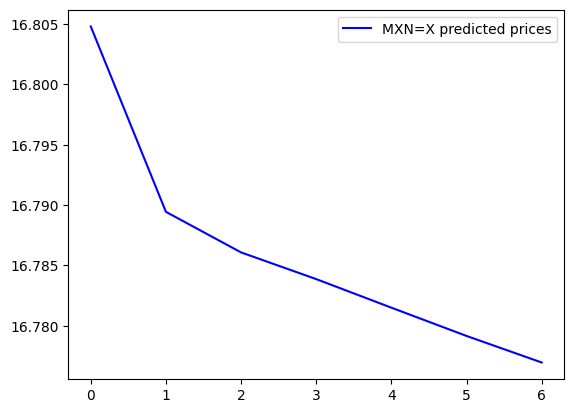

In [14]:

plt.plot(predicted_prices,color="blue",label=f"{company} predicted prices")
plt.legend()
plt.show()